# Ensemble Xgb


## Import Package


In [3]:
import time
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [86]:
import xgboost as xgb
import lightgbm as lgb

In [ ]:
from utils.metrics import evaluate
from utils.image import load_image_and_resize
from utils.datetime import get_taken_time, get_taken_month, transform_day_of_year

## Const & Inputs

Here are all of the parameters to change for the run.


In [1]:
# top level data directory. Here we assume the format of the directory conforms to the ImageFolder structure
path = "."

# Number of classes in the dataset
num_classes = 14

# Models for ensemble
models = [
    {
        'name': 'vit',
        'path': 'vision-transformer-result'
    }, 
    {
        'name': 'eff6',
        'path': 'efficientnetb6-transfer-trainable-epochs150-batchsize64-lrreducer-sampleweight-224'
    }, 
    # {
    #     'name': 'eff3',
    #     'path': 'efficientnetb3-transfer-trainable-epochs150-batchsize32-lrreducer-sampleweight-224'
    # }, 
    {
        'name': 'dcnn(doy-sig)',
        'path': 'dcnn-doy-1-sigmoid-conv12-heuniform-l2norm-adam-labelsmoothing-classweight'
    }, 
    {
        'name': 'dcnn(doy)',
        'path': 'dcnn-doy-3-conv12-heuniform-adam-labelsmoothing-classweight'
    }, 
    # {
    #     'name': 'dcnn(doy-sod)',
    #     'path': 'dcnn-doy-sod-3-conv14-heuniform-adam-labelsmoothing-classweight'  
    # },
    # {
    #     'name': 'dcnn',
    #     'path': 'dcnn-conv14-heuniform-adam-labelsmoothing-classweight'
    # }
]


## Data Preprocessing


### Load Data

Load the prediction results of 3 models and merge into a DataFrame.


In [9]:
# Read basic information of dataset
data = pd.read_csv(f'{path}/data/describe_train_fullset.csv').sort_values(by=['path']).reset_index(drop=True)
data.columns

Index(['path', 'true_label', 'taken_datetime', 'make', 'model', 'day_of_year',
       'transform_day_of_year', 'set_name'],
      dtype='object')

In [16]:
# Copy result from each model
for i in range(len(models)):
    result = pd.read_pickle(f'{path}/outputs/fullset/{models[i]["path"]}-train.pkl').sort_values(by=['path']).reset_index(drop=True)
    data[f'predict_prob_{models[i]["name"]}'] = result['predict_prob']
    data[f'pred_{models[i]["name"]}'] = result['pred_label']

# Generate datetime
data['taken_datetime'] = pd.to_datetime(data['taken_datetime'])
data['month'] = pd.to_datetime(data['taken_datetime']).dt.month
data['day_of_year'] = data['taken_datetime'].apply(lambda x: x.timetuple().tm_yday)
data['transform_day_of_year'] = data['day_of_year'].apply(lambda x: transform_day_of_year(x))

### Encode categorical features

OneHotEncoder or LabelEncoder.


In [177]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder

# One-hot for label
onehotenc = OneHotEncoder(handle_unknown='ignore')
onehotenc.fit(data['label'].values.reshape(-1, 1))

# Class for label
labelenc = LabelEncoder()
labelenc.fit(data['label'].values)
data['class'] = labelenc.transform(data['true_label'].values)

# Class for camera model
cameraenc = LabelEncoder()
cameraenc.fit(data['model'].values)
data['camera_class'] = cameraenc.transform(data['model'].values)

### Split Data & Evaluate

Split data into train, validation and test sets.


In [179]:
# Train
train = data[data['set_name'].eq('train')].reset_index(drop=True)

# Generate test from valid(8:2)
valid = data[data['set_name'].eq('valid')].reset_index(drop=True)
valid['isTest'] = np.nan
valid.groupby(['label', 'month']).apply(lambda x: valid["isTest"].fillna(pd.Series(data=1, index=x.sample(frac=0.2, random_state=5397).index), inplace=True))
test = valid[valid['isTest'].eq(1)].reset_index(drop=True)
test['set_name'] = 'test'

# Valid
valid = valid[~valid['isTest'].eq(1)].reset_index(drop=True)

In [23]:
# Evaluate each model on train
print('train')
for i in range(len(models)):
    evaluation = pd.DataFrame(evaluate(train['true_label'].tolist(), train[f'pred_{models[i]["name"]}'].tolist())).T
    print(models[i]["name"], round(evaluation['precision']['weighted avg'], 4))

# Evaluate each model on valid
print('valid')
for i in range(len(models)):
    evaluation = pd.DataFrame(evaluate(valid['true_label'].tolist(), valid[f'pred_{models[i]["name"]}'].tolist())).T
    print(models[i]["name"], round(evaluation['precision']['weighted avg'], 4))
    
# Evaluate each model on test
print('test')
for i in range(len(models)):
    evaluation = pd.DataFrame(evaluate(test['true_label'].tolist(), test[f'pred_{models[i]["name"]}'].tolist())).T
    print(models[i]["name"], round(evaluation['precision']['weighted avg'], 4))

train
vit 0.9997
eff6 1.0
eff3 1.0
dcnn(doy-sig) 0.9998
dcnn(doy) 0.9997
dcnn(doy-sod) 0.9999
dcnn 0.9995
valid
vit 0.9811
eff6 0.9778
eff3 0.9844
dcnn(doy-sig) 0.9745
dcnn(doy) 0.9779
dcnn(doy-sod) 0.9789
dcnn 0.9761
test
vit 0.9784
eff6 0.9803
eff3 0.9836
dcnn(doy-sig) 0.9773
dcnn(doy) 0.9766
dcnn(doy-sod) 0.9753
dcnn 0.9742


## Classification Prediction

Based on the output of each model.


In [ ]:
# ['XGBoost', 'LightGBM']
model_name = 'XGBoost'

In [180]:
def initialize_model(model_name, params, num_classes):
    # Initialize these variables which will be set in this if statement.
    # Each of these variables is model specific.
    model_ft = None

    if model_name == "LightGBM":
        model_ft = lgb.LGBMClassifier(**params)
        # model_ft = lgb.LGBMClassifier(objective='multiclass', num_class=14, device='gpu')
    elif model_name == "XGBoost":
        model_ft = xgb.XGBClassifier(**params)
        # model_ft = xgb.XGBClassifier(objective='multi:softproba', num_class=num_classes, eval_metric='auc', tree_method='gpu_hist', gpu_id=0)
    return model_ft

In [181]:
def build_x_y(df, models, list_of_use_models):
    # Build inputs of prob from each model
    x = np.concatenate([
        np.array(df[f'predict_prob_{models[i]["name"]}'].tolist()) for i in list_of_use_models
    ], axis=1)
    
    # Add doy & camera
    x = np.concatenate([
        x,
        df['transform_day_of_year'].values.reshape(-1, 1),
        df['camera_class'].values.reshape(-1, 1),
    ], axis=1)
    y = np.array(df['class'].tolist())
    return x, y

In [123]:
# Go through all the combinations
for midx in range(len(models)+1):
    # Obtain all models index
    list_of_use_models = [i for i in range(len(models))]
    
    # One of them is removed each time
    if(midx != len(models)):
        list_of_use_models.remove(midx)

    # Print the new model set
    model_set = '-'.join([models[i]["name"] for i in list_of_use_models])
    print(model_set)

    # Build x, y for model
    x_valid, y_valid = build_x_y(valid, models, list_of_use_models)
    x_test, y_test = build_x_y(test, models, list_of_use_models)

    # best_params = read_pkl(f'./models/vit-eff6-dcnn(doy-sig)-dcnn(doy)-Hyperopt1000.pkl')
    best_params= {'objective': 'multi:softproba', 'num_class': num_classes, 'eval_metric': 'auc', 'tree_method': 'gpu_hist', 'gpu_id': 0}

    # Create model & train
    clf = initialize_model(model_name, best_params, num_classes)
    clf.fit(x_valid, y_valid)

    # Predict the response for test dataset
    # y_pred = clf.predict(x_test)
    y_pred = clf.predict_proba(x_test)
    
    # Save the best model
    # clf.save_model(f"./models/ensemble/xgb(hpo)-{model_set}.json")

    y_pred_inverse = np.array(y_pred)

    # Transform the encoded predictions to their actual values
    # y_pred_inverse = labelenc.inverse_transform(y_pred)
    y_test_inverse = labelenc.inverse_transform(y_test)

    # Evaluate the model
    evaluation = evaluate(y_test_inverse.tolist(), y_pred_inverse.tolist())
    print(round(pd.DataFrame(evaluation).T['precision']['weighted avg'], 6))

0.986559
0.989321
0.990543
0.988021
0.988488
0.98894


#### Hyperparameter Optimization

2 & 5


In [132]:
from hyperopt import hp
from hyperopt import fmin, tpe, STATUS_OK, STATUS_FAIL, Trials

class HPOpt(object):

    def __init__(self, x_train, x_test, y_train, y_test):
        self.iteration = 0
        self.x_train = x_train
        self.x_test = x_test
        self.y_train = y_train
        self.y_test = y_test

    def process(self, fn_name, space, trials, algo, max_evals):
        fn = getattr(self, fn_name)
        try:
            result = fmin(fn=fn, space=space, algo=algo,
                          max_evals=max_evals, trials=trials)
        except Exception as e:
            return {'status': STATUS_FAIL,
                    'exception': str(e)}
        return {'result': result, 'history': trials}

    def xgb_clf(self, para):
        clf = xgb.XGBClassifier(**para['clf_params'])
        return self.train_clf(clf, para)

    def train_clf(self, clf, para):
        self.iteration += 1
        time_start = time.time()
        clf.fit(
            self.x_train, self.y_train,
            **para['fit_params']
        )
        pred = clf.predict(self.x_test)
        time_end = time.time()
        run_time = time_end - time_start

        loss = para['loss_func'](self.y_test, pred)
        return {'iteration': self.iteration, 'loss': loss, 'train_time': run_time, 'params': para, 'status': STATUS_OK}

In [134]:
from hyperopt.pyll.base import scope
# from hyperopt.pyll.stochastic import sample
# sample(scope.int(hp.quniform('example', 0, 10, 1)))
# Returns an integer from 0 to 10, inclusive

xgb_para = dict()
xgb_para['clf_params'] = {
    'objective':        'multi:softproba',   
    'num_class':        14,
    'tree_method':      'gpu_hist', 
    'gpu_id':           0,
    'eval_metric':      'auc',
    'booster':          'gbtree',
    'n_estimators':     scope.int(hp.quniform('n_estimators', 200, 2000, 100)),
    'learning_rate':    hp.loguniform('learning_rate', np.log(0.01), np.log(0.1)),
    'gamma':            hp.uniform ('gamma', 0.0, 4.0), # min_split_loss
    'max_depth':        scope.int(hp.quniform('max_depth', 3, 18, 1)),
    'min_child_weight': hp.quniform('min_child_weight', 1, 15, 1),
    'max_delta_step':   hp.quniform('max_delta_step', 0, 6, 1),
    'subsample':        hp.quniform('subsample', 0.4, 1, 0.1),
    'colsample_bytree': hp.quniform('colsample_bytree', 0.5, 1, 0.1),
    'reg_alpha':        hp.uniform('reg_alpha', 0.0, 1.0),  # L1 regularization
    'reg_lambda':       hp.uniform('reg_lambda', 0.0, 1.0), # L2 regularization
}
xgb_para['fit_params'] = {}
xgb_para['loss_func'] = lambda y, pred: -evaluate(y.tolist(), pred.tolist())['weighted avg']['precision']

2 vit-eff6-dcnn(doy-sig)-dcnn(doy)
100%|██████████| 500/500 [2:42:06<00:00, 19.45s/trial, best loss: -0.9909768822351733]  


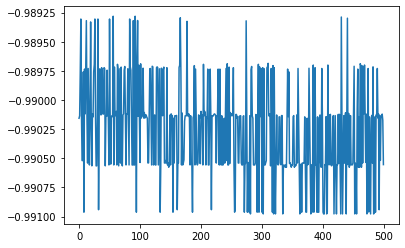

In [135]:
iteration = 500

# Obtain all models index
list_of_use_models = [i for i in range(len(models))]
# list_of_use_models.remove(2)
    
# Print model set
model_set = '-'.join([models[i]["name"] for i in list_of_use_models])
print(model_set)

x_valid, y_valid = build_x_y(valid, models, list_of_use_models)
x_test, y_test = build_x_y(test, models, list_of_use_models)
    
# Init
obj = HPOpt(x_valid, x_test, y_valid, y_test)

# Run optimization
trials = Trials()
opt = obj.process(fn_name='xgb_clf', space=xgb_para, trials=trials, algo=tpe.suggest, max_evals=iteration)

# Show best params 
history = pd.DataFrame(opt['history'].results)
best_params = history.loc[history['loss'].idxmin()]['params']['clf_params']

# (cpu)opt x2 = 19:56
# (gpu)opt x2 = 07:29, 1 = 4:30
# (gpu)opt x10 = 50:10, 1 = 5:00

# Save best params
best_params.to_pickle(f'{path}/models/{model_set}-hyperopt{iteration}-camera.pkl')
history.to_csv(f'{path}/models/{model_set}-hyperopt{iteration}-camera.csv')

# Drow loss
plt.plot(history['loss'])

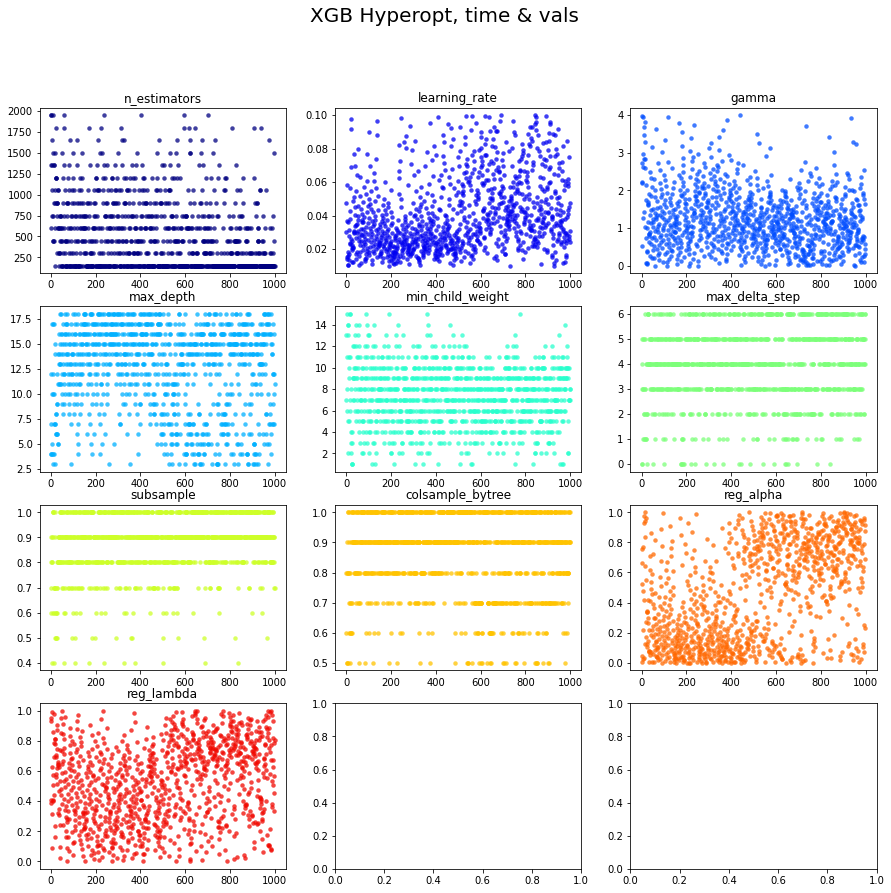

In [110]:
parameters = list(xgb_para['clf_params'].keys())[6:]
rows = (len(parameters)//3)+1
cols = 3
f, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(15, 14))
f.suptitle('XGB Hyperopt, time & vals', fontsize=20)
cmap = plt.cm.jet
for i, val in enumerate(parameters):
    xs = np.array([t['tid'] for t in trials.trials]).ravel()
    ys = np.array([t['misc']['vals'][val] for t in trials.trials]).ravel()
    axes[i//cols,i%cols].scatter(xs, ys, s=20, linewidth=0.01, alpha=0.75, color=cmap(float(i)/len(parameters)))
    axes[i//cols,i%cols].set_title(val)

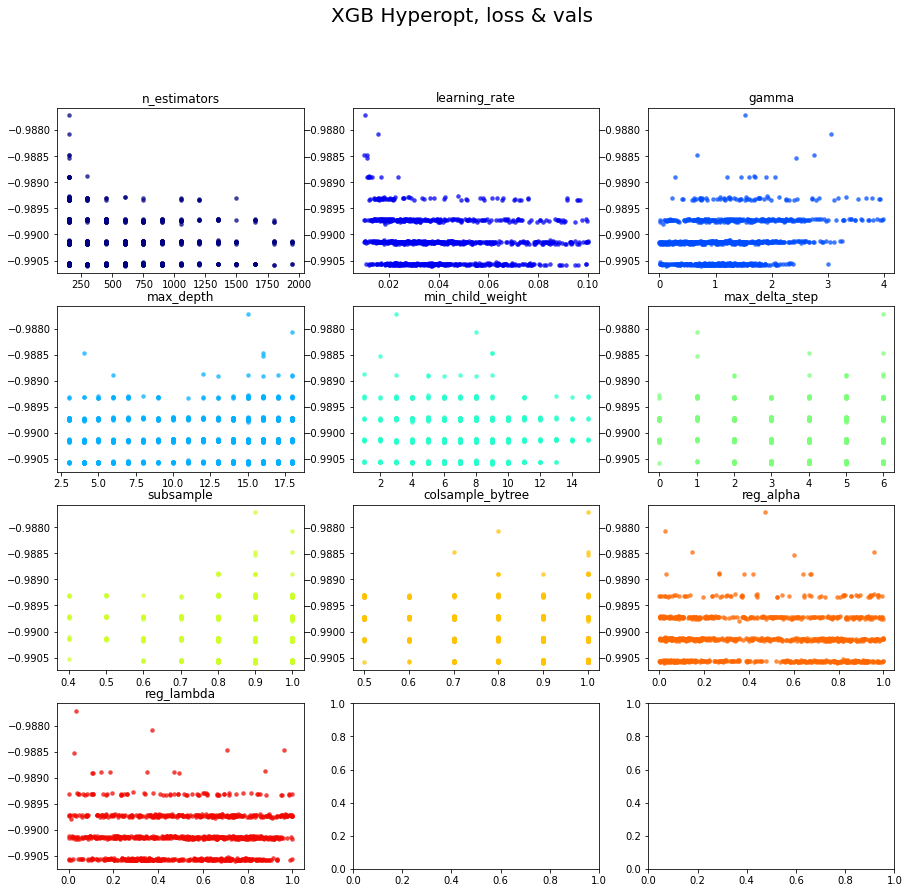

In [111]:
parameters = list(xgb_para['clf_params'].keys())[6:]
rows = (len(parameters)//3)+1
cols = 3
f, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(15, 14))
f.suptitle('XGB Hyperopt, loss & vals', fontsize=20)
cmap = plt.cm.jet
for i, val in enumerate(parameters):
    xs = np.array([t['misc']['vals'][val] for t in trials.trials]).ravel()
    ys = [t['result']['loss'] for t in trials.trials]
    axes[i//cols,i%cols].scatter(xs, ys, s=20, linewidth=0.01, alpha=0.75, color=cmap(float(i)/len(parameters)))
    axes[i//cols,i%cols].set_title(val)

### Save Results


In [ ]:
# Read basic information of dataset
submission = pd.read_csv(f'{path}/data/describe_train_fullset.csv').sort_values(by=['path']).reset_index(drop=True)
submission.columns

In [ ]:
# Copy result from each model
for i in range(len(models)):
    result = pd.read_pickle(f'{path}/outputs/fullset/{models[i]["path"]}-test.pkl').sort_values(by=['path']).reset_index(drop=True)
    submission[f'predict_prob_{models[i]["name"]}'] = result['predict_prob']
    submission[f'pred_{models[i]["name"]}'] = result['pred_label']

# Generate datetime
submission['taken_datetime'] = pd.to_datetime(submission['taken_datetime'])
submission['month'] = pd.to_datetime(submission['taken_datetime']).dt.month
submission['day_of_year'] = submission['taken_datetime'].apply(lambda x: x.timetuple().tm_yday)
submission['transform_day_of_year'] = submission['day_of_year'].apply(lambda x: transform_day_of_year(x))

# Class transform
submission['camera_class'] = cameraenc.transform(submission['model'].values)

In [192]:
# ['XGBoost', 'LightGBM']
model_name = 'XGBoost'

# Build model set
list_of_use_models = [i for i in range(len(models))]

# Print model set
model_set = '-'.join([models[i]["name"] for i in list_of_use_models])
print(model_set)

vit-eff6-dcnn(doy-sig)-dcnn(doy)


In [193]:
# Build x, y for model
x_submission, y_submission = build_x_y(submission, models, list_of_use_models)

# best_params = read_pkl(f'./models/vit-eff6-dcnn(doy-sig)-dcnn(doy)-Hyperopt500(camera).pkl')
best_params= {'objective': 'multi:softproba', 'num_class': num_classes, 'eval_metric': 'auc', 'tree_method': 'gpu_hist', 'gpu_id': 0}

# Create the model [LightGBM, XGBoost]
clf = initialize_model(model_name, best_params, num_classes)

# load model
clf.load_model(f"./models/ensemble/xgb-{model_set}-camera.json")

# Predict the response for test dataset
y_pred_inverse = clf.predict_proba(x_submission)
# y_pred = clf.predict(x_submission)

# Output result
submission['label'] = list(y_pred_inverse)
submission['image_filename'] = submission['path'].apply(lambda x: x.split('/')[-1])
submission[['image_filename', 'label']].to_csv(f'./submission/xgb(camera)-{model_set}.csv', index=False)    

### Playground #1

使用 score 作為門檻，若預測類別的信心程度不足，就將它從 Soybean 替換為 Peanut


In [ ]:
labels = [
    'banana', 'bareland', 'carrot', 'corn', 'dragonfruit', 
    'garlic', 'guava', 'peanut', 'pineapple', 'pumpkin', 'rice', 'soybean', 'sugarcane', 'tomato'
]

# Build new dataframe with second and thrid predict result
df = pd.DataFrame()
df['true_label'] = y_test_inverse
df['pred_label'] = y_pred_inverse
df['pred_prob'] = list(y_pred)
df['pred_label_second'] = df['pred_prob'].apply(lambda x: labels[np.argsort(x, axis=0)[-2]])
df['pred_label_thrid'] = df['pred_prob'].apply(lambda x: labels[np.argsort(x, axis=0)[-3]])

# Calculate score from probability
df['pred_score'] = df['pred_prob'].apply(lambda x: x.max())

# Set mask
mask1 = df['pred_label'].isin(['peanut', 'soybean'])
mask2 = df['pred_score']<0.6
maskdf = df[mask1 & mask2]
maskdf[['true_label', 'pred_label', 'pred_label_second', 'pred_label_thrid', 'pred_score']]

In [ ]:
# Use MASK replacement prediction results
# df.loc[maskdf[maskdf['pred_label'].isin(['peanut'])].index.tolist(), 'pred_label'] = 'soybean'
# df.loc[maskdf[maskdf['pred_label'].isin(['soybean'])].index.tolist(), 'pred_label'] = 'peanut'
# df.loc[maskdf[maskdf['pred_label'].isin(['peanut'])].index.tolist(), 'pred_label'] = df.loc[maskdf[maskdf['pred_label'].isin(['peanut'])].index.tolist(), 'pred_label_second']
# df.loc[maskdf[maskdf['pred_label'].isin(['soybean'])].index.tolist(), 'pred_label'] = df.loc[maskdf[maskdf['pred_label'].isin(['soybean'])].index.tolist(), 'pred_label_second']

In [ ]:
# Calculation method results
evaluation = evaluate(df['true_label'].tolist(), df['pred_label'].tolist())
print(round(pd.DataFrame(evaluation).T['precision']['weighted avg'], 6))